In [11]:
# importing necessary packages
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas as pd

In [21]:
data = pd.read_csv('agridata333.csv')


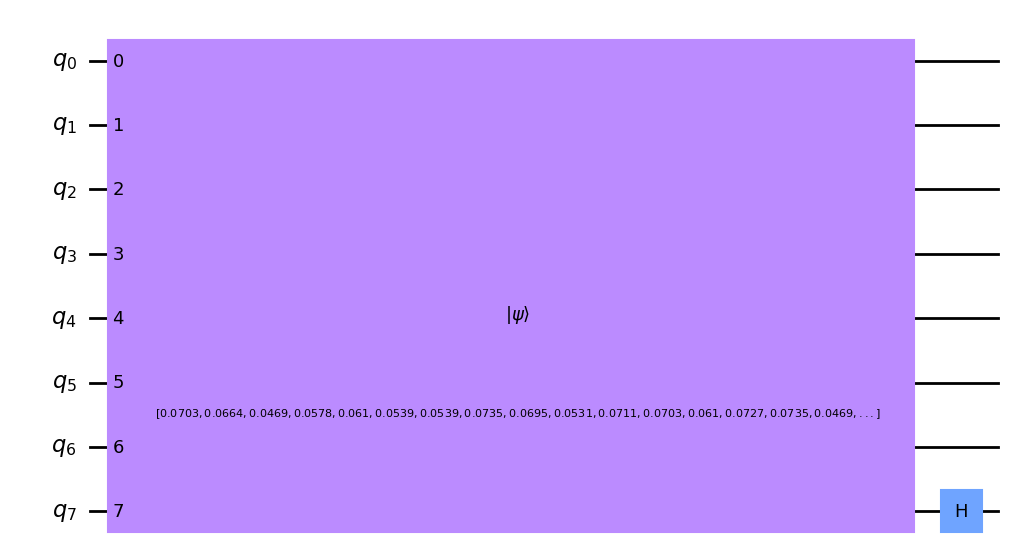

In [22]:
x = data['N']  # define some vectors x and y
y = data['P']

N = len(x)              
nqubits = math.ceil(np.log2(N))    # compute how many qubits needed to encode either x or y

xnorm = np.linalg.norm(x)          # normalise vectors x and y
ynorm = np.linalg.norm(y)
x = x/xnorm
y = y/ynorm

circ = QuantumCircuit(nqubits+1)   # create circuit
vec = np.concatenate((x,y))/np.sqrt(2)    # concatenate x and y as above, with renormalisation

circ.initialize(vec, range(nqubits+1))
circ.h(nqubits)                    # apply hadamard to bottom qubit

circ.draw()                        # draw the circuit

In [23]:
#Creates a quantum circuit to calculate the inner product between two normalised vectors

def inner_prod(vec1, vec2):
    #first check lengths are equal
    if len(vec1) != len(vec2):
        raise ValueError('Lengths of states are not equal')
        
    circ = QuantumCircuit(nqubits+1)
    vec = np.concatenate((vec1,vec2))/np.sqrt(2)
    
    circ.initialize(vec, range(nqubits+1))
    circ.h(nqubits)

    backend = Aer.get_backend('statevector_simulator')
    job = execute(circ, backend)
    
    result = job.result()
    o = np.real(result.get_statevector(circ))

    m_sum = 0
    for l in range(N):
        m_sum += o[l]**2
        
    return 2*m_sum-1

x = np.arange(0,8,1)
y = x

N = len(x)
nqubits = math.ceil(np.log2(N))
xnorm = np.linalg.norm(x)
ynorm = np.linalg.norm(y)
x = x/xnorm
y = y/ynorm

print("x: ", x)
print()
print("y: ", y)
print()
print("The inner product of x and y equals: ", inner_prod(x,y))

x:  [0.         0.08451543 0.16903085 0.25354628 0.3380617  0.42257713
 0.50709255 0.59160798]

y:  [0.         0.08451543 0.16903085 0.25354628 0.3380617  0.42257713
 0.50709255 0.59160798]

The inner product of x and y equals:  0.9999999999999996


In [24]:
#Implements the entire cost function by feeding the ansatz to the quantum circuit which computes inner products

def calculate_cost_function(parameters):

    a, b = parameters
    
    ansatz = a*x + b                        # compute ansatz
    ansatzNorm = np.linalg.norm(ansatz)     # normalise ansatz
    ansatz = ansatz/ansatzNorm
    
    y_ansatz = ansatzNorm/ynorm * inner_prod(y,ansatz)     # use quantum circuit to test ansatz
                                                           # note the normalisation factors
    return (1-y_ansatz)**2

x = np.arange(0,8,1)
y = x

N = len(x)
nqubits = math.ceil(np.log2(N))
ynorm = np.linalg.norm(y)
y = y/ynorm

a = 1.0
b = 1.0
print("Cost function for a =", a, "and b =", b, "equals:", calculate_cost_function([a,b]))

Cost function for a = 1.0 and b = 1.0 equals: 0.03999999999999998


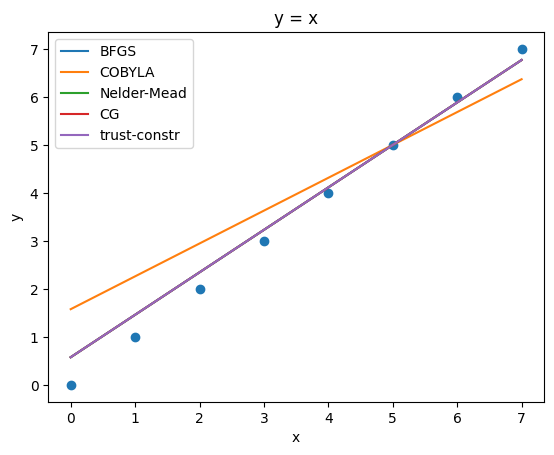

In [25]:
#first set up the data sets x and y

x = np.arange(0,8,1)
y = x   # + [random.uniform(-1,1) for p in range(8)]    # can add noise here
N = len(x)
nqubits = math.ceil(np.log2(N))
       
ynorm = np.linalg.norm(y)      # normalise the y data set
y = y/ynorm

x0 = [0.5,0.5]                 # initial guess for a and b

#now use different classical optimisers to see which one works best

out = minimize(calculate_cost_function, x0=x0, method="BFGS", options={'maxiter':200}, tol=1e-6)
out1 = minimize(calculate_cost_function, x0=x0, method="COBYLA", options={'maxiter':200}, tol=1e-6)
out2 = minimize(calculate_cost_function, x0=x0, method="Nelder-Mead", options={'maxiter':200}, tol=1e-6)
out3 = minimize(calculate_cost_function, x0=x0, method="CG", options={'maxiter':200}, tol=1e-6)
out4 = minimize(calculate_cost_function, x0=x0, method="trust-constr", options={'maxiter':200}, tol=1e-6)

out_a1 = out1['x'][0]
out_b1 = out1['x'][1]

out_a = out['x'][0]
out_b = out['x'][1]

out_a2 = out2['x'][0]
out_b2 = out2['x'][1]

out_a3 = out3['x'][0]
out_b3 = out3['x'][1]

out_a4 = out4['x'][0]
out_b4 = out4['x'][1]

plt.scatter(x,y*ynorm)
xfit = np.linspace(min(x), max(x), 100)
plt.plot(xfit, out_a*xfit+out_b, label='BFGS')
plt.plot(xfit, out_a1*xfit+out_b1, label='COBYLA')
plt.plot(xfit, out_a2*xfit+out_b2, label='Nelder-Mead')
plt.plot(xfit, out_a3*xfit+out_b3, label='CG')
plt.plot(xfit, out_a4*xfit+out_b4, label='trust-constr')
plt.legend()
plt.title("y = x")
plt.xlabel("x")
plt.ylabel("y")
plt.show()